In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

In [6]:
torch.cuda.is_available()

False

In [3]:
# Set up a training data set for pcb anomaly detection
path = "/Users/ryan/Documents/PCB-Forensics/data/autoencoder-data/More_training_data"

ic_s = [cv2.imread(os.path.join(path, im))/255 for im in os.listdir(path)]
X = np.array(ic_s)
labels = np.ones(len(X))


batch_size=32

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.1, random_state=3)
X_train, X_test = X_train.transpose(0, 3, 1, 2), X_test.transpose(0, 3, 1, 2)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
aug_X_train1 = torch.rot90(X_train, 1, [2, 3])
aug_X_train2 = torch.rot90(X_train, 2, [2, 3])

X_train = torch.cat((X_train, aug_X_train1, aug_X_train2))
y_train = torch.cat((y_train, torch.ones(len(y_train)),torch.ones(len(y_train))))

In [4]:

dataset = TensorDataset(X_train,y_train) # create your datset
train_loader = DataLoader(dataset, batch_size=batch_size) # create your dataloader


valset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test)) # create your test set
val_loader = DataLoader(valset, batch_size=batch_size) # create your test loader

dataiter = iter(train_loader)
data, _ = next(dataiter)
print("Check the shape of the training data [Batch size, image shape]")
print(data.shape)

Check the shape of the training data [Batch size, image shape]
torch.Size([32, 3, 400, 400])


In [5]:
data= data[0, :, :, :]z

In [37]:
mod = nn.Conv2d(3, 32, 2, stride = 2, padding = 2)
x = mod(data)
mod =  nn.ReLU()
x = mod(x)
mod = nn.Conv2d(32, 64, 5, stride = 1, padding = 2)
x = mod(x)
mod =  nn.ReLU()
x = mod(x)
mod = nn.Conv2d(64, 128, 5, stride = 2, padding = 0)
x = mod(x)
mod = nn.Conv2d(128, 256, 5, stride = 1, padding = 0)

x = mod(x)
mod = nn.MaxPool2d(2, 2)
x = mod(x)

mod = nn.ConvTranspose2d(256, 128, 5, stride = 2, padding = 0)
x = mod(x)
mod = nn.ConvTranspose2d(128, 64, 5, stride = 2, padding = 2)
x = mod(x)
mod = nn.ConvTranspose2d(64, 32, 5, stride = 2, padding = 2)
x = mod(x)
mod = nn.ConvTranspose2d(32, 3, 2, stride = 1, padding = 2)
x = mod(x)
mod = nn.Sigmoid()
x = mod(x)

In [38]:
x.shape

torch.Size([3, 382, 382])

In [39]:
import torch.nn as nn
from torchvision import transforms

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # B, 3, 400, 400
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 2, stride = 2, padding = 6),
            nn.ReLU(),
            nn.Conv2d(64, 192, 5, stride = 2, padding = 2),
            nn.ReLU(),
            nn.Conv2d(192, 192, 5, stride = 2, padding = 0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(192, 300, 5, stride = 2, padding = 0),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(300, 64, 5, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 5, stride = 2, padding = 1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride = 2, padding = 0),
            nn.Sigmoid()
        )

    def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            transform = transforms.Resize(size = (400,400))
            x = transform(decoded)
            return x


device = 'mps'
model = CNNAutoencoder().to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-5, weight_decay = 1e-5)

Epoch:1, Loss:21.8759


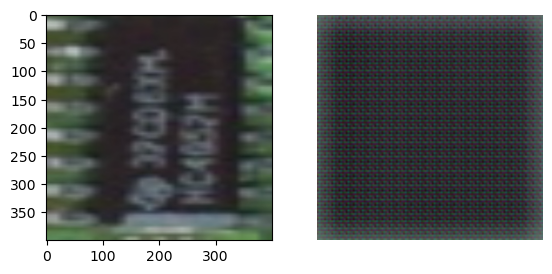

Epoch:2, Loss:13.9387
Epoch:3, Loss:8.1238
Epoch:4, Loss:6.1412
Epoch:5, Loss:5.4649
Epoch:6, Loss:5.0003
Epoch:7, Loss:4.8173
Epoch:8, Loss:4.6921
Epoch:9, Loss:4.5843
Epoch:10, Loss:4.5026


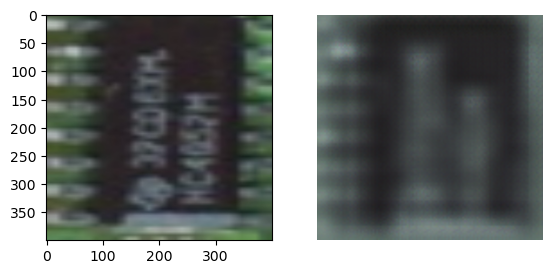

Epoch:11, Loss:4.4366
Epoch:12, Loss:4.3805
Epoch:13, Loss:4.3321
Epoch:14, Loss:4.2844
Epoch:15, Loss:4.2375
Epoch:16, Loss:4.1886
Epoch:17, Loss:4.1394
Epoch:18, Loss:4.0915
Epoch:19, Loss:4.0499
Epoch:20, Loss:4.0120


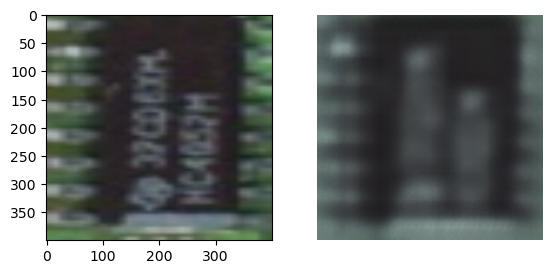

Epoch:21, Loss:3.9670
Epoch:22, Loss:3.9324
Epoch:23, Loss:3.9022
Epoch:24, Loss:3.8719
Epoch:25, Loss:3.8360
Epoch:26, Loss:3.7803
Epoch:27, Loss:3.7329
Epoch:28, Loss:3.6963
Epoch:29, Loss:3.6598
Epoch:30, Loss:3.6260


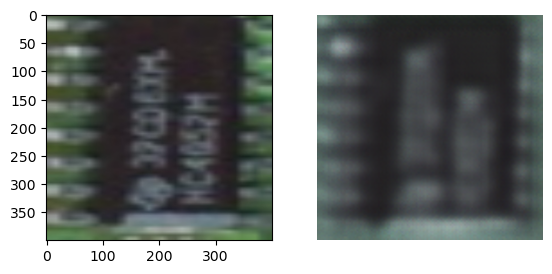

Epoch:31, Loss:3.5908
Epoch:32, Loss:3.5574
Epoch:33, Loss:3.5271
Epoch:34, Loss:3.5008
Epoch:35, Loss:3.4786
Epoch:36, Loss:3.4589
Epoch:37, Loss:3.4375
Epoch:38, Loss:3.4191
Epoch:39, Loss:3.4012
Epoch:40, Loss:3.3858


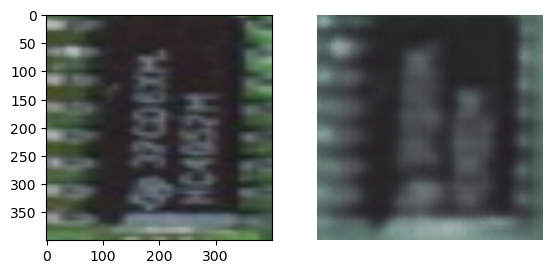

Epoch:41, Loss:3.3717
Epoch:42, Loss:3.3595
Epoch:43, Loss:3.3421
Epoch:44, Loss:3.3213
Epoch:45, Loss:3.3041
Epoch:46, Loss:3.2884
Epoch:47, Loss:3.2753
Epoch:48, Loss:3.2715
Epoch:49, Loss:3.2947
Epoch:50, Loss:3.2518


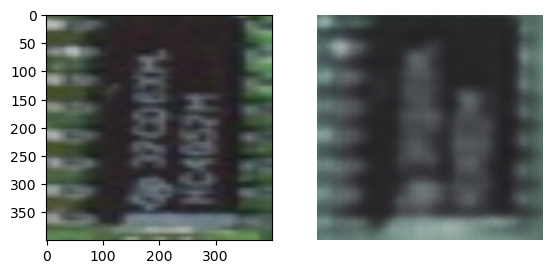

Epoch:51, Loss:3.2289
Epoch:52, Loss:3.2285
Epoch:53, Loss:3.2333
Epoch:54, Loss:3.2228
Epoch:55, Loss:3.2006
Epoch:56, Loss:3.1876
Epoch:57, Loss:3.1812
Epoch:58, Loss:3.1757
Epoch:59, Loss:3.1738
Epoch:60, Loss:3.1699


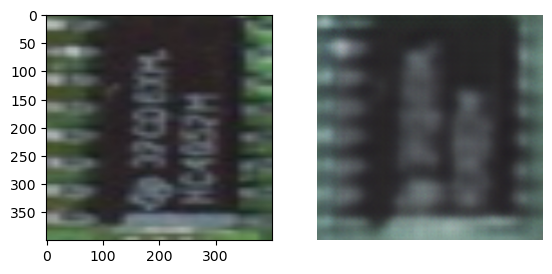

Epoch:61, Loss:3.1481
Epoch:62, Loss:3.1219
Epoch:63, Loss:3.1019
Epoch:64, Loss:3.0717
Epoch:65, Loss:3.0057
Epoch:66, Loss:2.9604
Epoch:67, Loss:2.9222
Epoch:68, Loss:2.9438
Epoch:69, Loss:2.8739
Epoch:70, Loss:2.8507


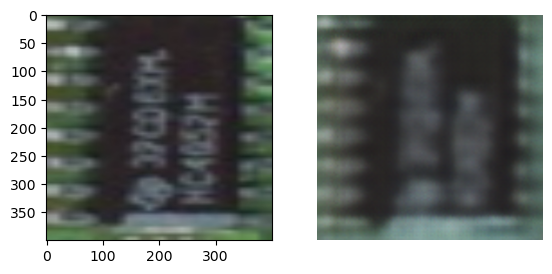

Epoch:71, Loss:2.8370
Epoch:72, Loss:2.8204
Epoch:73, Loss:2.8026
Epoch:74, Loss:2.7861
Epoch:75, Loss:2.7720
Epoch:76, Loss:2.7637
Epoch:77, Loss:2.7640
Epoch:78, Loss:2.8078
Epoch:79, Loss:2.8991
Epoch:80, Loss:2.6956


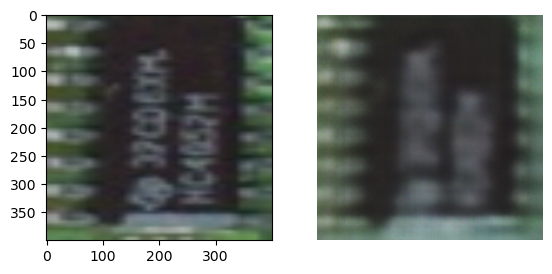

Epoch:81, Loss:2.6638
Epoch:82, Loss:2.6409
Epoch:83, Loss:2.6368
Epoch:84, Loss:2.6375
Epoch:85, Loss:2.6357
Epoch:86, Loss:2.6300
Epoch:87, Loss:2.6216
Epoch:88, Loss:2.6122
Epoch:89, Loss:2.6037
Epoch:90, Loss:2.5946


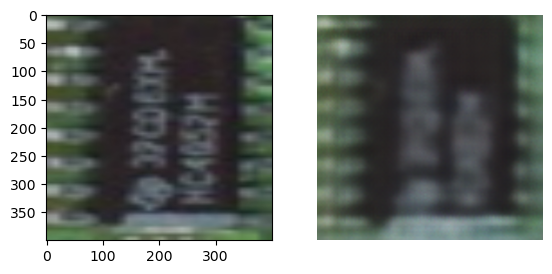

Epoch:91, Loss:2.5867


In [40]:
# Point to training loop video
early_stopper = 0

num_epochs = 300
outputs = []
valoutputs = []
for epoch in range(num_epochs):
    
    try:
        this_loss = loss.item()
    except:
        this_loss = 100

    for (img, _) in train_loader:
        model.train()
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)*img.size(2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon, round(loss.item(), 4)))
    if epoch == 0:
        imgs1 = img.permute(0, 2, 3, 1)
        econ1 = recon.permute(0, 2, 3, 1)
        fig = plt.figure()
        ax = fig.add_subplot(1,2, 1)
        ax.imshow(imgs1[0].cpu())
        ax = fig.add_subplot(1,2, 2)
        ax.imshow(econ1[0].detach().cpu().numpy())
        plt.axis(False)
        plt.show()
    elif (epoch + 1) % 10 == 0:
        imgs1 = img.permute(0, 2, 3, 1)
        econ1 = recon.permute(0, 2, 3, 1)
        fig = plt.figure()
        ax = fig.add_subplot(1,2, 1)
        ax.imshow(imgs1[0].cpu())
        ax = fig.add_subplot(1,2, 2)
        ax.imshow(econ1[0].detach().cpu().numpy())
        plt.axis(False)
        plt.show()
    if abs(this_loss - loss.item()) < 0.00001:
        early_stopper += 1
        if early_stopper > 5:
            break

    for (img, _) in val_loader:
        model.eval()
        img = img.to(device)
        recon = model(img)
        valloss = criterion(recon, img)*img.size(2)
        

    valoutputs.append(round(valloss.item(), 4))
    



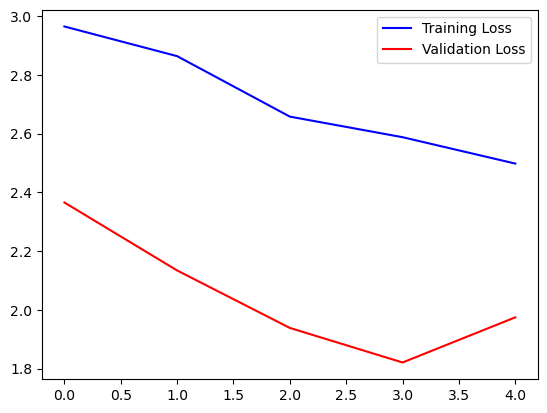

In [10]:
model_loss = [ls[3] for ls in outputs]
plt.plot(model_loss, label='Training Loss', linestyle = "-", color = 'b')
plt.plot(valoutputs, linestyle = "-", color = 'red')

plt.legend(["Training Loss", "Validation Loss"])
plt.show()

IndexError: list index out of range

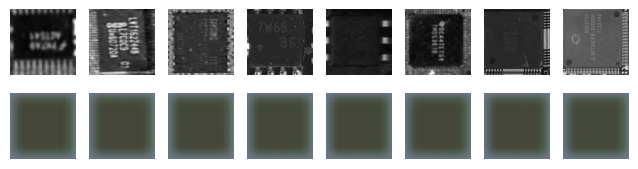

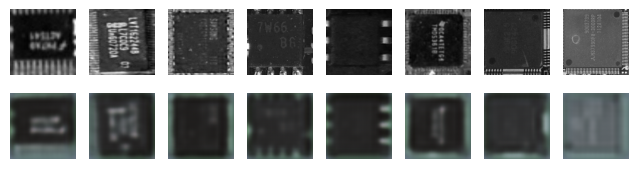

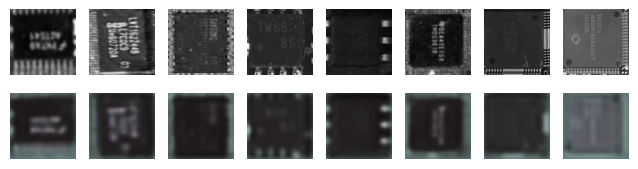

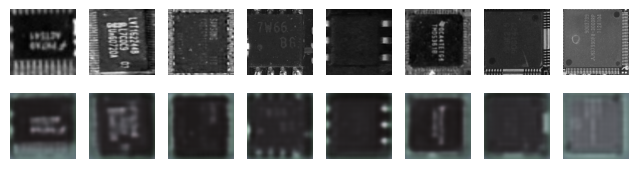

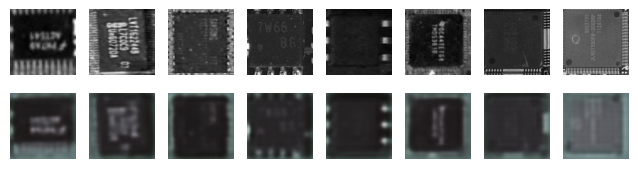

<Figure size 900x200 with 0 Axes>

In [ ]:
for k in range(0, num_epochs,15):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    imgs1 = imgs.transpose(0, 2 ,3, 1)
    recon1 = recon.transpose(0, 2 ,3, 1)
    for i, item1 in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item1 = item1 # -> use for Autoencoder_Linear
        plt.imshow(item1[0])
        plt.axis(False)
            
    for i, item2 in enumerate(recon1):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item2 = item2 # -> use for Autoencoder_Linear
        plt.imshow(item2)
        plt.axis(False)

In [ ]:
model.eval()
model.to(device)

loss = [criterion(model(img.to(device)), img.to(device)).item() for (img, _) in testloader]

<function matplotlib.pyplot.show(close=None, block=None)>

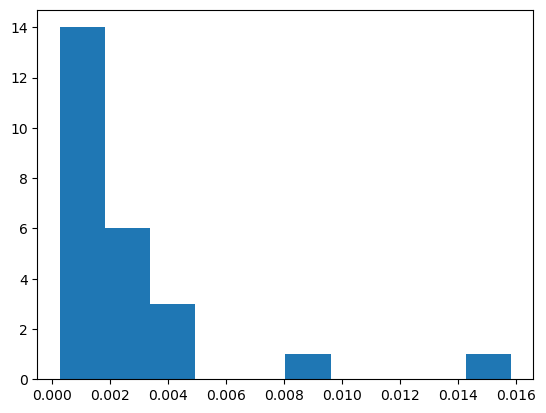

In [ ]:
plt.hist(loss)
plt.show

In [ ]:
try:
    os.makedirs('../models')
except:
    pass
torch.save(model, '../models/IC_AE_mps.pth')

# model = torch.load('../models/IC_AE.pth')
model.eval()


CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2), padding=(6, 6))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    (7): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (7): Sigmoid()
  )
)

In [ ]:
cpus = torch.device('cpu')
model.to(cpus)
try:
    os.makedirs('../models')
except:
    pass
torch.save(model, '../models/IC_AE_cpu.pth')

In [ ]:
torch.save(model.state_dict(), '../models/IC_AE-dict-cpu.pth')
